# Using Random Forest and Exreme Gradient Boosting for Housing  Price Prediction

## Introduction:

This notebook will showcase the preprocessing of the kaggle housing prices dataset and application of two ensemble models, a Random Forest model, and a Gradient Boosting model to accurately predict housing prices. The final product will be submitted to a Kaggle competiton for ranking in a leaderboard.

### What is a Random Forest Model?
At its core a Random Forest Model is an extension of a the Decision Tree Regressor Model.

Let's start by discussing the Decision Tree and then how we expand it into a Random Forest.

#### Decision Trees:
A decision tree is a [non-parametric model](https://en.wikipedia.org/wiki/Nonparametric_statistics) that recursively splits data into subsets and works to minimize the variance based on some measurement, in our case we will be using mean absolute error (MAE). Below is a diagram explaining how this works.

We start with a house and begin assessing based on features. The more features we add the more complex the model becomes. This can lead to a more accurate model but it depends on us choosing good features to allow the model to make good decisions. Garbage in is garbage out. For instance, the number of bedrooms and lot footage definitely affect a houses price, but would the number of birds that live on the property? Probably not, unless it's a rather large and rude number of crows.

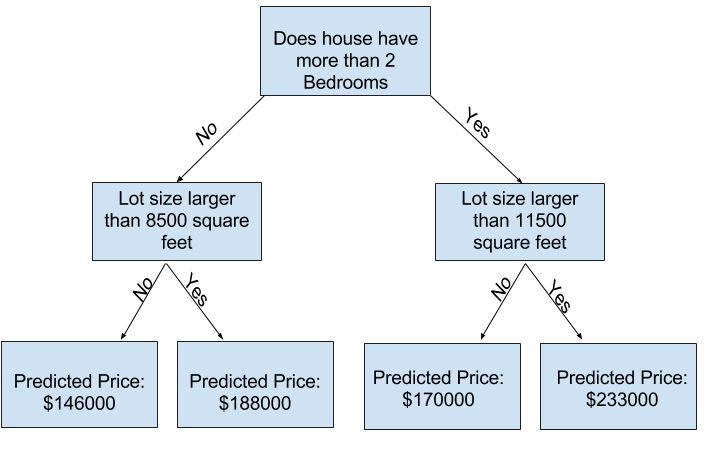

Image from [Kaggle Course: Introduction to Machine Learning](https://www.kaggle.com/code/dansbecker/how-models-work)

### Extending into random forest:
Now suppose we have a decision tree and it's doing a brilliant job, in fact it's got near 100% accuracy! We've taken a look at our dataset and we've decided what features we are going to use to predict but we've run into a bit of a problem.

Everytime we try to use our model on data it hasn't seen its guesses are *wildly* incorrect. This is the result of something called **Overfitting**. It is the result of our tree creating a node for every variable within every feature for the data it was trained on. In simplest terms our decision tree memorized the data instead of learning how to reason out the correct answer based on available information. There is another problem we can run into which is not giving our tree enough depth, very shallow roots if you will, that will result in **Underfitting** wherein there aren't enough leaves/nodes to accurately predict an outcome given the available features.

So what do we do? Do we have a little tree that underfits, or a great big tree with deep roots that overfits? What if we had another option? What if instead of a single tree we had a whole bunch of trees?

This is where Random Forest models come in to play. It's a collection of decision trees, and just like a real forest, every tree is going to look at different pieces of the dataset. It's what's called an *ensemble* model because it's a collection (ensemble) of models. It will randomly select subsets of features and data to create different trees, and then average the predictions of the trees in the forest. This also improves variance because the forest takes the average across trees and is thus less sensitive to small changes.

At this point we're ready to talk about preprocessing data and getting into some actual code!

## Data Preprocessing

Recall earlier when I mentioned data is sort of garbage in garbage out? Data is very messy in real life, it's got missing values, incorrect entries, features we don't need, the list goes on.

We are going to need some tools to help deal with that. We'll be using two, [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)) and [encoding](https://www.geeksforgeeks.org/feature-encoding-techniques-machine-learning/).

**Imputation** helps us by dealing with missing values by replacing them, often with the mean or median value of the set.

**Encoding** helps us by converting categorical data into numerical values. It can accomplish this in a few ways ordering groups using label encoding, or if there is no real order it might be better to use one hot encoding. Both have advantages and disadvantages based on your dataset.

I encourage you to read through the links provided if you want a more in-depth explanation.

The next thing we need to consider is **validation**, first off you are a good person, and people say nice things about you. Now that we've taken care of you let's talk about how to do that with our dataset.

We need to validate our model and make sure its predictions are accurate. One of the ways we can do this is by holding out a portion of data and testing our model on it.

Say we use 80% of our dataset for training and 20% for validation testing. This is not a bad method, one of the drawbacks is that in order to get more accurate measures of our model's quality we need to sure a larger portion of our training data resulting in less data available to train our model. We certainly can't validate it on data it's been trained on, that's touching on something called *data leakage*.

This is where **cross-validation** comes into play. We will be using k-fold cross-validation. Suppose we take our dataset and divide it into parts. We will train our model on 80% of the data and validate with the remaining 20% just like before. The key differnce here, is that we are going to do this 4 more times with different portions of the data being used for training and validation.

By doing this piecewise we are able to use 100% of our dataset for validation.

Something to be mindful of when we do this is the tradeoff between accuracy and efficiency. Cross-Validation will be more accurate than just using a holdout set but it is much more expensive computationally! k = 5 and k = 10 are common starting points for optimizing your dataset.

Now, with all that background out of the way, let's begin coding. First we will import our dataset and start preprocessing it.

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('/content/train.csv', index_col='Id')
test_data = pd.read_csv('/content/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

We have imported Pandas, and one of the tools from SciKit learn, we will import more as we work through this. Then we dropped na values, and separated our target y from our predictors X.

Then selected only numeric columns in the dataset using a for loop. This is an important step because some models such as random forest cannot take categorical data, recall our discussion of encoding earlier. Most importantly we saved all this into a **copy** of the original dataset with only numeric columns. This weay we still have the original dataset to work with.

## Setting up the Random Forest Model

We are going to use something called pipelines here. I personally prefer the implementation in seen in R but Scikit has an implemenation that is sufficient. You can read a great explanation of pipes here [R for Data Science](https://r4ds.had.co.nz/pipes.html). Essentially what pipelines do is make the code easier to understand by making it readable as a stepwise process instead of having to dissect more traditional code.

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

data_processing_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('random_forest_model', RandomForestRegressor(n_estimators= 200, random_state=0))
]

)

Now we have a pipeline that will finish cleaning our data and fit a model to it. n_estimators is the number of trees we will use and we set a random state to ensure reproducibility.

In [33]:
from sklearn.model_selection import cross_val_score

scores = -1 * cross_val_score(data_processing_pipeline, X, y,
                              cv = 5, # try setting this to 100 (get a snack first)
                              scoring = 'neg_mean_absolute_error'
                              )

print(f"Average MAE score: {scores.mean()}")

Average MAE score: 17937.141941780825


We have successfully used a pipeline to preprocess our data by imputing and then trained our random forest model model. I picked some of the model parameters based on trial and error trying to minimize the score. I recomend you change the following to see what kind of impact it has on our MAE.

*   n_estimators
*   cv

Before we move on to extreme gradient boosting we need to touch on some of the math that went on here.

# Math Behind Decision Tree Regression and Extreme Gradient Boosting

### Decision Tree

Recall that the decision tree takes the data and divides it into leaves/nodes, you may have asked "OK *how* does it do that?", and then gotten very upset when you discovered that I elaborated no further. Well fear not for here we shall elaborate.

You see, the decision tree is spending all of it's time trying to do one very important thing. *Minimize Variance*, it accomplishes this by using a **loss function**, which it is trying to minimize. You may also hear them called error functions or cost functions, they refer to the same thing. There are a few options for loss functions but one of the most common for regression problems,  is the **Mean Squared Error**.

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Nice equation, What does it mean? This is the symbolic way of saying the mean squared error is equal to the sum of the squared value of $y_i$ (the actual value) minus $\hat{y}_i$ (predicted value) divided by the total number of observations n. If you take on thing away from this section please let it be that, *We want this number to be as small as possible*. Small MSE means small cost function means *close to the actual value*.

Now at each node of our tree the data is split into two subsets, the optimal split is determined by minimizing the weighted average of the MSE for each dataset. It will try splitting data in different ways and pick the smallest MSE, this is repeated recursively until the tree is built.

WAIT! We used MAE not MSE! Well good news, MAE is very similar to MSE. Why absolute value? MSE punishes larger errors more harshly by squaring them, but MAE treats all with equal weight.

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

Note the similarity, however MAE is more robust in the face of outliers because it doesn't punish larger errors as harshly, it is also easier to interpret the magnitude of your model's error. To a certain extent picking your cost function is dependent on your dataset and research/business question. Choose the one that fits your needs, MSE when you want to penalize large errors harshly, and MAE when you expect outliers.

### Extreme Gradient Boosting

We will be discussing gradient boosting, but extreme makes it sound cooler and is the version we will be using in our implementation.

A gradient boosting model works by adding models over time. We start with a model, make predictions, calculate a loss function, train a new model to correct the predictions of ther previous model, and add it to the ensemble and make predictions. The general idea is that the added models will "boost" performance by improving predictions for difficult to predict data points. We want to train this model until it cannot reduce the loss function further, or the changes are so small it not worth the time and energy.

It accomplishes this using a method called **gradient descent**. We are going to go into more depth but the simplest explanation of gradient descent is that for the first time in your life your goal is to hit rock bottom as fast and as accurately as possible. It accomplishes this by looking stepwise for a path downhill to a global minimum by calculating the negative gradient of our loss function.

First let's build up our gradient boosting model.

We start with our initial model:

$$
f_0(x) = \text{mean}(y)
$$

This is pretty much what we've seen before.

Then we calclulate our errors or residuals:

$$
r_i = y_i - f_0(x_i)
$$

Our actual value y minus some function of x that is our predicted value is equal to our residual.

Next we train a new decision tree based on the residuals and add it to the ensemble to further minimized our loss function:

$$
f_m(x) = f_{m-1}(x) + \eta \cdot h_m(x)
$$

We simply add an updated model with a hyperparameter $\eta$ (eta) that controls how big of a correction, or step downhill, is made to adjust our prediction towards minimizing our error.

This addition of a new model predicting the negative gradient and course correcting towards a minimized error is repeated until the loss function is minimized to the best of our (the model's) ability.

Now the most important bit of gradient boosting is gradient descent, 3Blue1Brown does a wonderful job of covering it [here](https://www.youtube.com/watch?v=IHZwWFHWa-w). A quick detour to refresh your calculus can be found [here](https://tutorial.math.lamar.edu/pdf/calculus_cheat_sheet_derivatives.pdf)
You don't actually need to do any calculus right now but it's important to understand the context of what's happening because this is used extensively in machine learning once you dive into neural nets and deep learning.

For our purpose, because we are using MSE, the negative gradient (remember we are moving downhill towards a minimum) of our loss function is defined as the partial derivative of our loss function with respect to our function is equal to difference between our actual and predicted values.

$$
\frac{\partial L}{\partial f(x)} = y_i - f(x_i)
$$

The model being added (boosting) the ensemble, is trained to predict the residuals (negative gradient of the loss function) of the previous model.

Now that we have explained all of this let's get into the actual code. A lot of this will be similar or identical to what we did with the random forest model, but we are going to implement some encoding as well.


In [39]:
# Read the data
X2 = pd.read_csv('/content/train.csv', index_col='Id')
X_test_full = pd.read_csv('/content/test.csv', index_col='Id')

# Drop NA
X2.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X2.SalePrice
X2.drop(['SalePrice'], axis=1, inplace=True)

# Split training and validation data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X2, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


# Select categorical columns with relatively low cardinality (easier to deal with)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

We have prepared our data, now we bring out our pipeline and impute some data.

In [40]:
# import Xtreme Gradient Boost
from xgboost import XGBRegressor

boosting_processing_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('gradient_boost_model', XGBRegressor(n_estimators = 350, learning_rate = 0.05))
]
)

# Fit model
boosting_processing_pipeline.fit(X_train, y_train)

# Get predictions
predictions_full = boosting_processing_pipeline.predict(X_test)

Now it's time to write our predictions to a CSV and submit them to the kaggle contest.

In [41]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': predictions_full})
output.to_csv('/content/submission.csv', index=False)

You can submit the predictions to the Housing Prices Competition [here](https://www.kaggle.com/competitions/home-data-for-ml-course)

It's not my best submission, but it's close, and 4,414 out of 184,356 entrants isn't half bad!

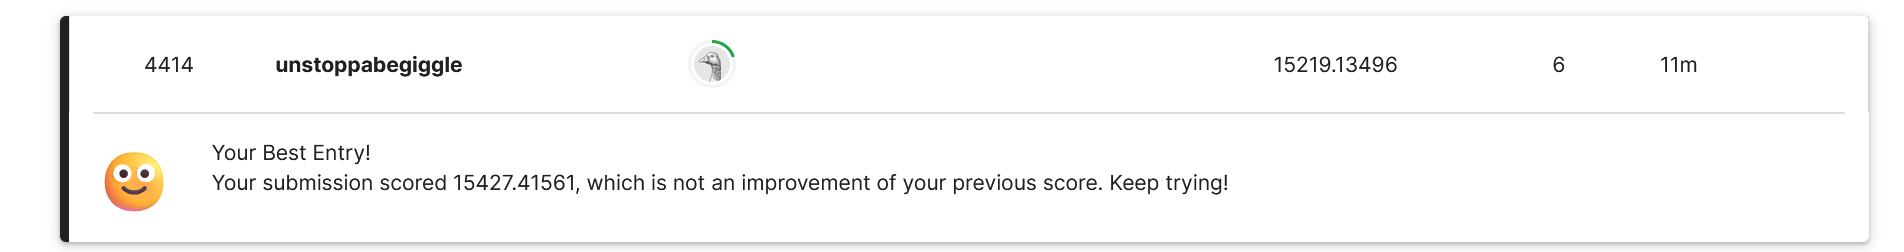
